In [1]:
from detect import getBoundingBox
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from transformers import AutoModel, AutoTokenizer
import torch

### Detect Bounding boxes

In [2]:
image_path = 'C://ML Resume//License plate recognition//dataset//train//images//AQUA5_26144_checkin_2020-10-23-17-140HcLE8JWTi_jpg.rf.013f68954bfd36cf1adaf317099db3a1.jpg'
xyxy = getBoundingBox(image_path, 0.6)


image 1/1 C:\ML Resume\License plate recognition\dataset\train\images\AQUA5_26144_checkin_2020-10-23-17-140HcLE8JWTi_jpg.rf.013f68954bfd36cf1adaf317099db3a1.jpg: 640x416 1 plate, 51.8ms
Speed: 5.5ms preprocess, 51.8ms inference, 152.3ms postprocess per image at shape (1, 3, 640, 416)


In [3]:
def draw_bbox(image_path, xyxy, color=(0, 255, 0), thickness=2):
    image = cv.imread(image_path)
    for box in xyxy:
        cv.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, thickness)
    return image

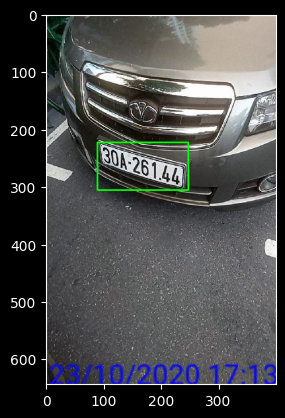

In [4]:
plt.imshow(draw_bbox(image_path, xyxy))

### Preprocess

In [5]:
def process_pipeline(image_path, xyxy, delta=0.1, limit=5, max_value=255, adaptive_method=cv.ADAPTIVE_THRESH_GAUSSIAN_C,
                     threshold_type=cv.THRESH_BINARY_INV, block_size=15, C=7, kernel_size=(2, 2), iterations=1):
    im = cv.imread(image_path)
    cropped = crop_bbox(im, xyxy)
    gray = cv.cvtColor(cropped, cv.COLOR_BGR2GRAY)

    thresh = cv.adaptiveThreshold(gray, max_value, adaptive_method, threshold_type, block_size, C)

    kernel = np.ones(kernel_size, np.uint8)
    thresh = cv.dilate(thresh, kernel, iterations=iterations)
    thresh = cv.erode(thresh, kernel, iterations=iterations)

    kernel = cv.getStructuringElement(cv.MORPH_RECT, (2, 2))
    cleaned = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)

    angles = np.arange(-limit, limit + delta, delta)
    img_stack = np.stack([rotate_image(cleaned, angle) for angle in angles], axis=0)
    scores = determine_score(img_stack)
    best_angle = angles[np.argmax(scores)]
    corrected = rotate_image(cropped, best_angle)
    clean_im = clean_image(corrected, max_value, adaptive_method, threshold_type, block_size, C, kernel_size, iterations)

    return best_angle, clean_im

def crop_bbox(image, xyxy):
    image = image[int(xyxy[0][1]):int(xyxy[0][3]), int(xyxy[0][0]):int(xyxy[0][2])]
    return image

def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv.getRotationMatrix2D(center, angle, 1.0)
    corrected = cv.warpAffine(image, M, (w, h), flags=cv.INTER_CUBIC, borderMode=cv.BORDER_REPLICATE)
    return corrected

def determine_score(arr):
    histogram = np.sum(arr, axis=2, dtype=float)
    score = np.sum((histogram[..., 1:] - histogram[..., :-1]) ** 2, axis=1, dtype=float)
    return score

def clean_image(im, max_value=255, adaptive_method=cv.ADAPTIVE_THRESH_GAUSSIAN_C, threshold_type=cv.THRESH_BINARY_INV, block_size=15, C=7, kernel_size=(2, 2), iterations=1):
    gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    
    blured = cv.GaussianBlur(gray, (5, 5), 0)
    bfilter = cv.bilateralFilter(blured, 11, 17, 17) 
    edged = cv.Canny(bfilter, 30, 200) 

    return edged

def prepare_image_for_model(image):
    resized = cv.resize(image, (24, 24))  
    tensor_image = torch.tensor(resized).long().cuda()  
    return tensor_image

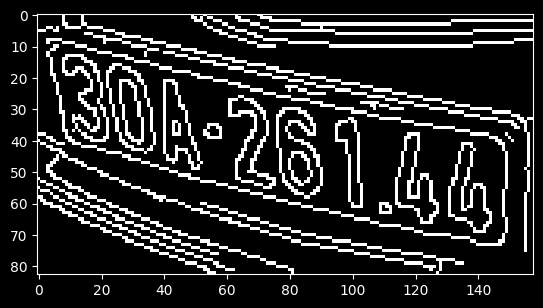

In [6]:

angle, im_processed = process_pipeline(image_path, xyxy)
plt.imshow(im_processed, cmap='gray');

In [7]:
prepared_image = prepare_image_for_model(im_processed)
prepared_image.shape

torch.Size([24, 24])

### OCR

In [8]:
tokenizer = AutoTokenizer.from_pretrained('ucaslcl/GOT-OCR2_0', trust_remote_code=True)
model = AutoModel.from_pretrained('ucaslcl/GOT-OCR2_0', trust_remote_code=True, low_cpu_mem_usage=True, device_map='cuda', use_safetensors=True, pad_token_id=tokenizer.eos_token_id)
model = model.eval().cuda()

In [9]:
import gc
gc.collect()

0

In [10]:
def save_temp_image(image, filename='temp_image.png'):
    cv.imwrite(filename, image)
    return filename

In [11]:
im_path = save_temp_image(im_processed, filename='temp_image.png')

In [12]:
model = model.to("cuda")    
res = model.chat(tokenizer, im_path, ocr_type='ocr')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
c:\Python311\Lib\site-packages\transformers\models\qwen2\modeling_qwen2.py:580: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


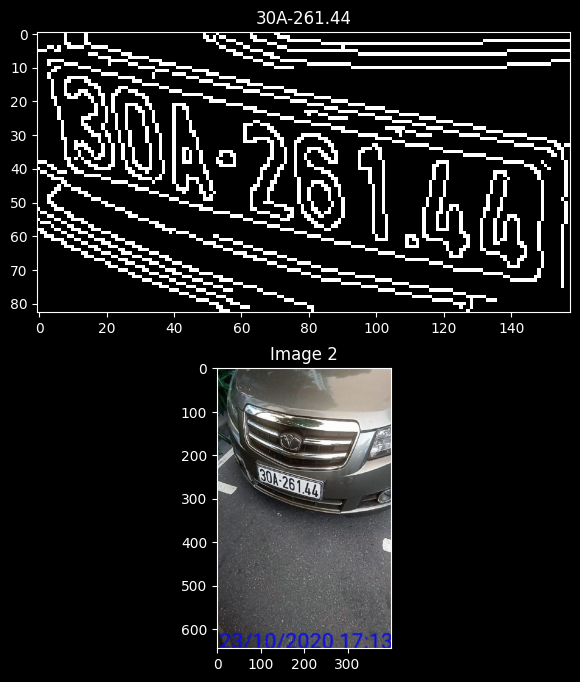

In [13]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

ax1.imshow(cv.imread(im_path))
ax1.set_title(res)

ax2.imshow(cv.imread(image_path))
ax2.set_title('Image 2')

plt.show()

In [14]:
from preprocess_image import process_pipeline as processPipe

In [15]:
angle, clean = processPipe(image_path, xyxy)

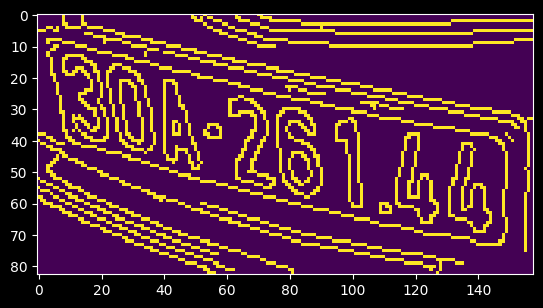

In [16]:
plt.imshow(clean)

---
---
PRESENTATION

---
---

In [17]:
import os
import random

images = os.listdir('dataset/train/images')

indices = random.sample(range(len(images)), 4)
picked_images = []

[picked_images.append(os.path.join('dataset/train/images', images[index])) for index in indices]
picked_images

['dataset/train/images\\AQUA2_31553_checkin_2020-11-2-14-45U4k9PB_334_jpg.rf.1eb77217f1fc195f29c2d6414c1e2dc7.jpg',
 'dataset/train/images\\AQUA2_50483_checkin_2020-10-28-18-193H0q6KEtIM_jpg.rf.face6274226405bd0a24aef96a4c663f.jpg',
 'dataset/train/images\\0409_05079_b_jpg.rf.03beb7b88fe9951984b0568e0f964575.jpg',
 'dataset/train/images\\AQUA7_38452_checkoutex_2020-10-24-9-56bCvjjFKTky_jpg.rf.8b0de4869dece722dab50efc72ef36b2.jpg']


image 1/1 c:\ML Resume\License plate recognition\dataset\train\images\AQUA2_31553_checkin_2020-11-2-14-45U4k9PB_334_jpg.rf.1eb77217f1fc195f29c2d6414c1e2dc7.jpg: 640x416 1 plate, 19.9ms
Speed: 3.0ms preprocess, 19.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 416)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.



image 1/1 c:\ML Resume\License plate recognition\dataset\train\images\AQUA2_50483_checkin_2020-10-28-18-193H0q6KEtIM_jpg.rf.face6274226405bd0a24aef96a4c663f.jpg: 640x416 1 plate, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 416)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.



image 1/1 c:\ML Resume\License plate recognition\dataset\train\images\0409_05079_b_jpg.rf.03beb7b88fe9951984b0568e0f964575.jpg: 416x640 1 plate, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.



image 1/1 c:\ML Resume\License plate recognition\dataset\train\images\AQUA7_38452_checkoutex_2020-10-24-9-56bCvjjFKTky_jpg.rf.8b0de4869dece722dab50efc72ef36b2.jpg: 640x416 1 plate, 12.5ms
Speed: 2.6ms preprocess, 12.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 416)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


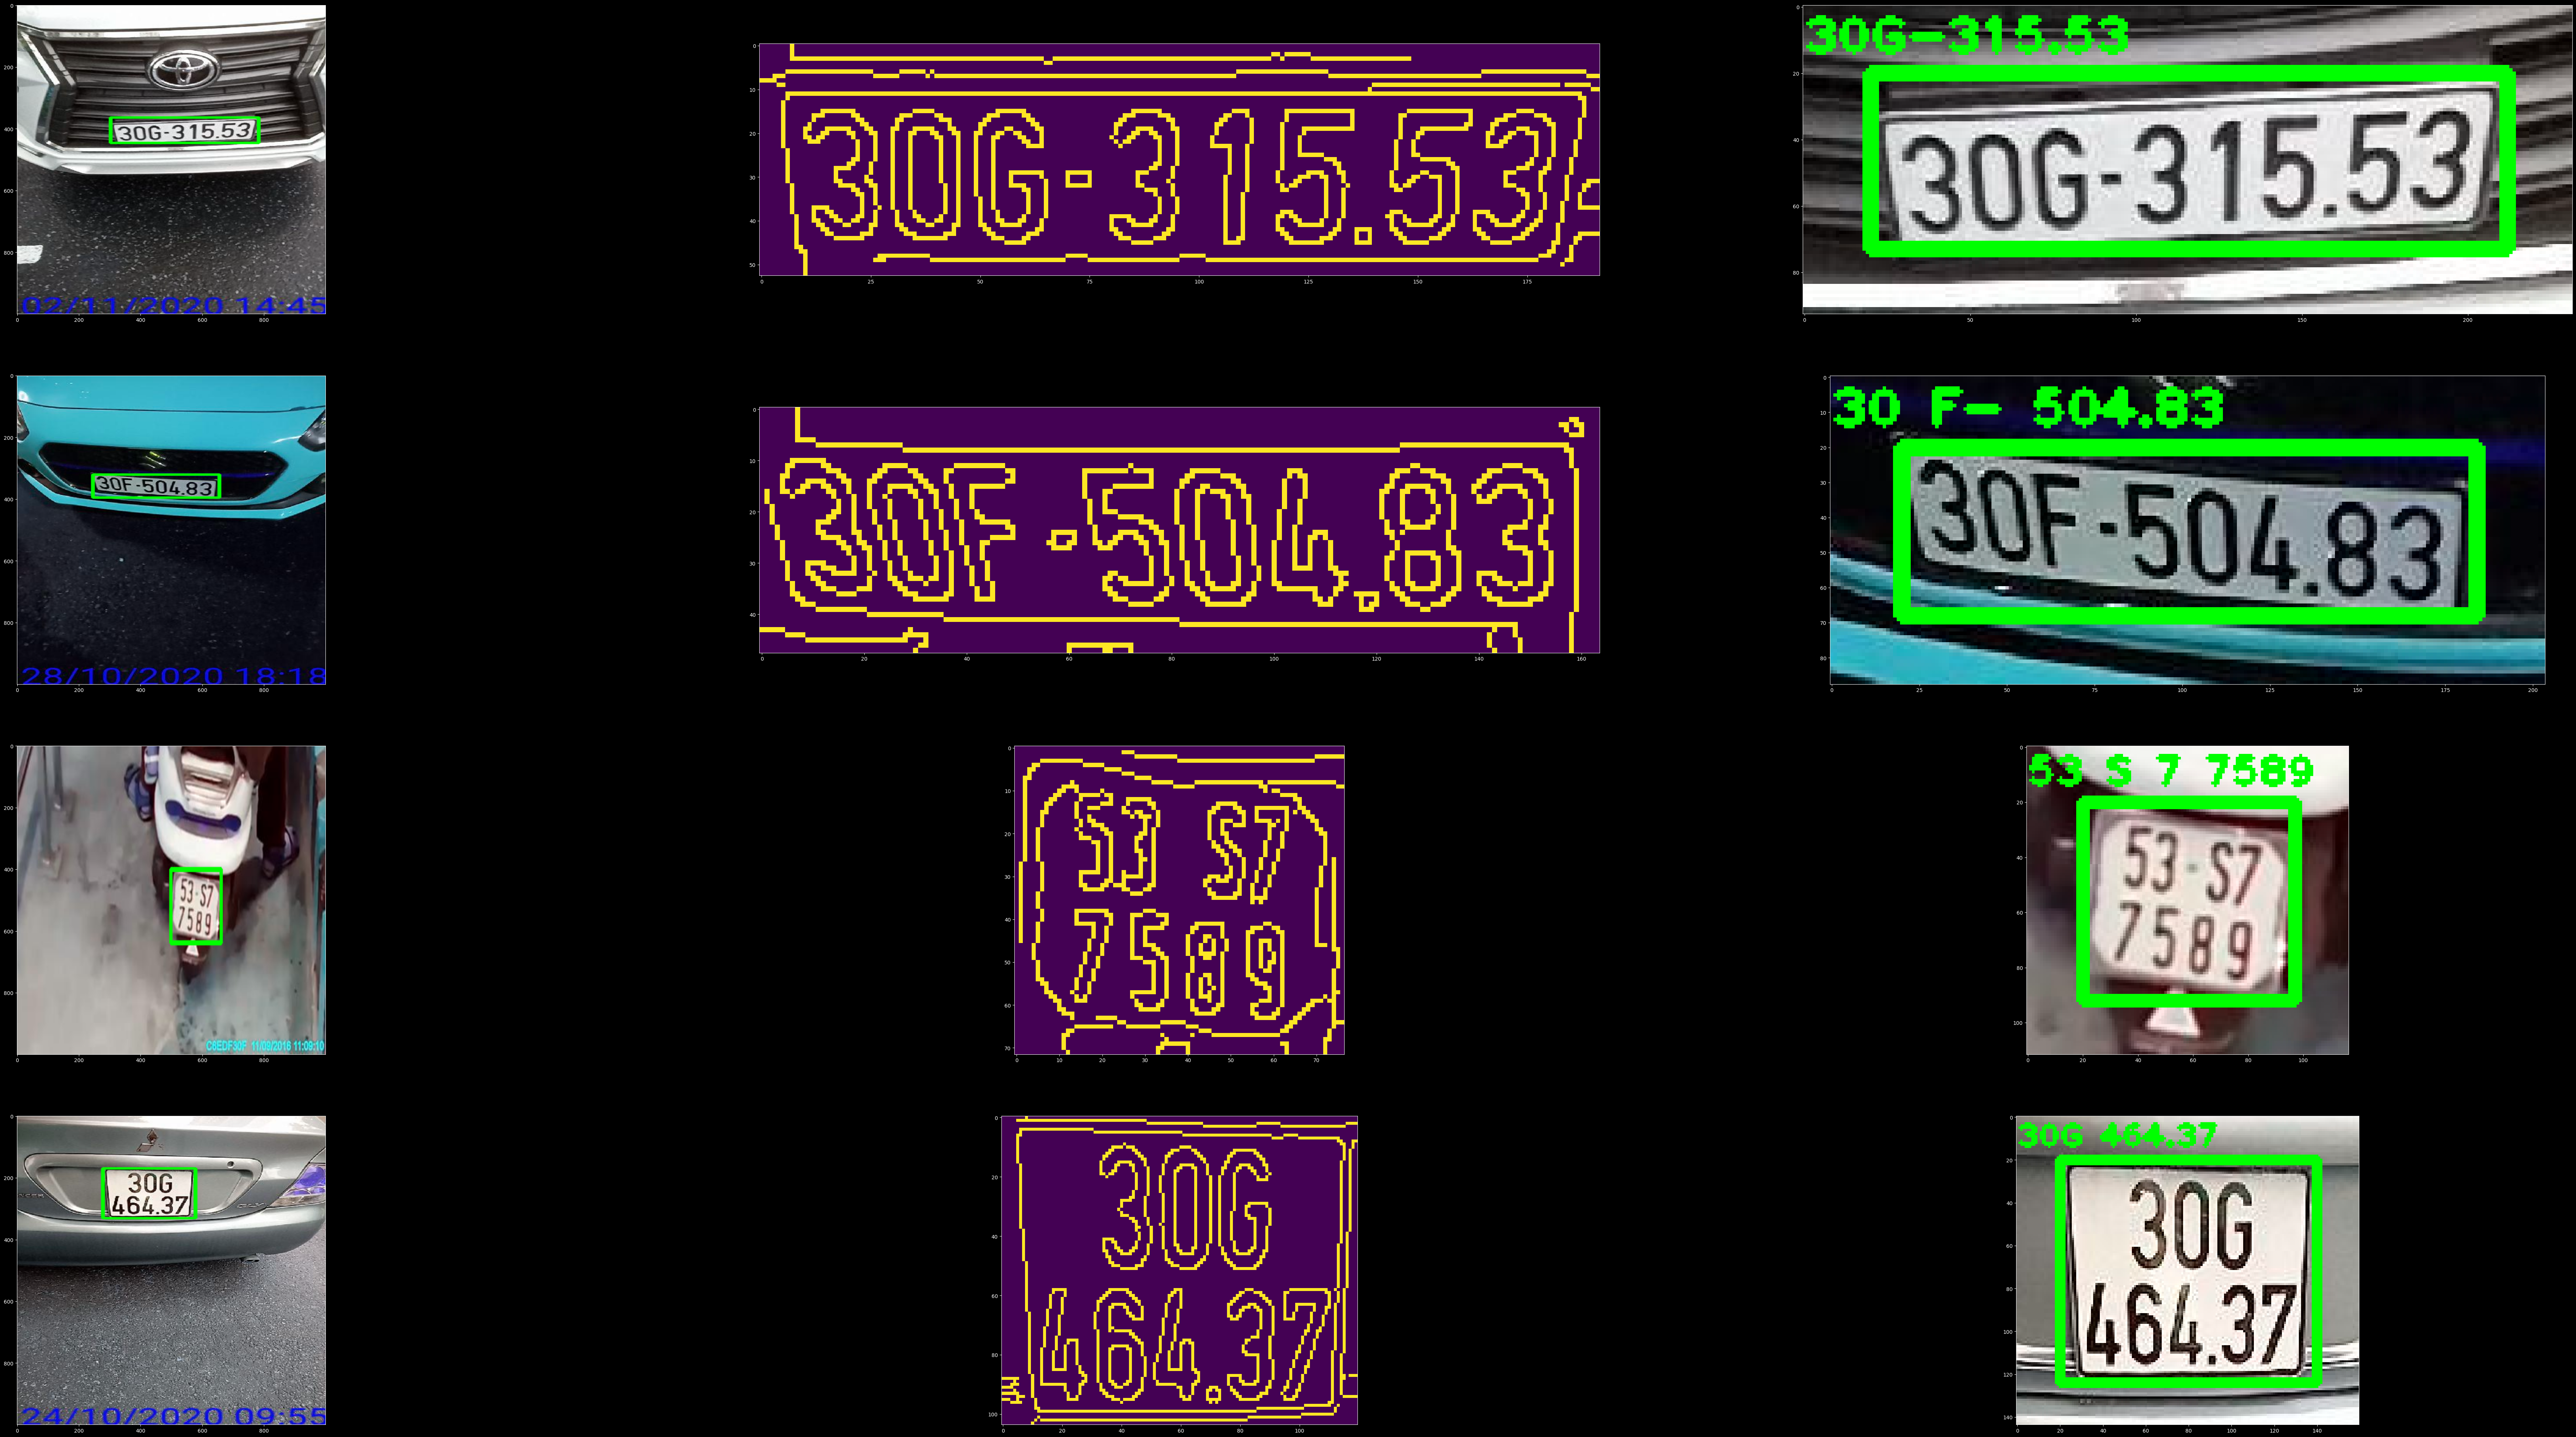

In [30]:
fig, axs = plt.subplots(4, 3)
fig.set_figwidth(100)
fig.set_figheight(50)

for i, impath in enumerate(picked_images):
    xyxy        = getBoundingBox(impath, 0.7)
    _, im = process_pipeline(impath, xyxy, block_size=21)
    im_path = save_temp_image(im, filename='temp_image.png')
    res = model.chat(tokenizer, im_path, ocr_type='ocr')
    im_with_box = draw_bbox(impath, xyxy, thickness=3)
    im_with_box2 = cv.resize(im_with_box, (1000, 1000))
    
    x1, y1, x2, y2 = xyxy[0]
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
    cv.putText(im_with_box, res, (x1-20, y1-6), 1, 1, (0,255,0), 2)
    im_out = im_with_box[y1-20: y2+20, x1-20: x2+20]
    
    axs[i, 0].imshow(im_with_box2)
    axs[i, 1].imshow(im)
    axs[i, 2].imshow(im_out)
    
    
plt.show();